In [3]:
## import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import calendar
from numpy import percentile
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [4]:
# read review, listing and calendar data
data_review = pd.read_csv('C:/reviews.csv')
data_listing = pd.read_csv('C:/listings.csv')
data_calendar = pd.read_csv('C:/calendar.csv')

In [5]:
# a function that formats variables like price,rates, dates
def cleaned_data(data):
    
    # Convert string of prices to floats
    
    data['price_y'] = data['price_y'].astype(str).str.replace('$','')
    data['price_y'] = data['price_y'].astype(str).str.replace(',','')
    data['price_y'] = data['price_y'].astype(float)
    
    data['weekly_price'] = data['weekly_price'].astype(str).str.replace('$','')
    data['weekly_price'] = data['weekly_price'].astype(str).str.replace(',','')
    data['weekly_price'] = data['weekly_price'].astype(float)
    
    data['monthly_price'] = data['monthly_price'].astype(str).str.replace('$','')
    data['monthly_price'] = data['monthly_price'].astype(str).str.replace(',','')
    data['monthly_price'] = data['monthly_price'].astype(float)
    
    data['extra_people'] = data['extra_people'].astype(str).str.replace('$','')
    data['extra_people'] = data['extra_people'].astype(str).str.replace(',','')
    data['extra_people'] = data['extra_people'].astype(str).astype(float)
    
    data['cleaning_fee'] = data['cleaning_fee'].astype(str).str.replace('$','')
    data['cleaning_fee'] = data['cleaning_fee'].astype(str).str.replace(',','')
    data['cleaning_fee'] = data['cleaning_fee'].astype(str).astype(float)
    
    data['security_deposit'] = data['security_deposit'].astype(str).str.replace('$','')
    data['security_deposit'] = data['security_deposit'].astype(str).str.replace(',','')
    data['security_deposit'] = data['security_deposit'].astype(float)
    
    
    data['host_acceptance_rate'] = data['host_acceptance_rate'].astype(str).str.replace('%','')
    data['host_acceptance_rate'] = data['host_acceptance_rate'].astype(float)
    
    data['host_response_rate'] = data['host_response_rate'].astype(str).str.replace('%','')
    data['host_response_rate'] = data['host_response_rate'].astype(float)
    
    data['date'] = pd.to_datetime(data['date'])
    data['host_since'] = pd.to_datetime(data['host_since'])

    data['month']=data.date.dt.month
    data['year']=data.host_since.dt.year

  
    return data

In [6]:
# merge listing and calendar data sets to find correlation between price and other features
data_listing = data_listing.rename(columns={'id' : 'listing_id'})
data_new = data_listing.merge(data_calendar , on ='listing_id')
Data_Revenue = cleaned_data(data_new)


In [7]:
# drop the rows having zero prices
Data_Revenue.dropna(axis=0,subset=['price_y'],inplace=True)

# merge data revenue and review and clean it
Data_Revenue = Data_Revenue.merge(data_review, on ='listing_id')
Data_Revenue = cleaned_data(data_new)

In [10]:
# how many rows and columns
Data_Revenue.shape

(65318, 38)

In [460]:
# select important variables I think might be Correlated to price 
colmns =['listing_id','property_type', 'room_type','bathrooms', 'bedrooms','accommodates','beds','year',\
                                     'host_is_superhost','availability_365','availability_30','availability_60',\
                                     'availability_90','number_of_reviews','price_y','bed_type',\
                                     'require_guest_phone_verification','cancellation_policy','require_guest_profile_picture',\
                                     'review_scores_value','review_scores_rating',\
                                     'review_scores_cleanliness','review_scores_communication','minimum_nights','guests_included',\
                                     'cleaning_fee','host_response_rate','host_response_time','host_acceptance_rate',\
                                     'instant_bookable', 'host_total_listings_count',\
                                     'neighbourhood_cleansed','extra_people','reviews_per_month','available','review_scores_accuracy','security_deposit']

Data_Revenue = Data_Revenue[colmns]

# since I selected the important variables, it is time to remove duplicates 
Data_Revenue = Data_Revenue.drop_duplicates()
Data_Revenue.dropna(axis=0,subset=['price_y'],inplace=True)

In [427]:
Data_Revenue.head()

,listing_id,property_type,room_type,bathrooms,bedrooms,accommodates,beds,year,host_is_superhost,availability_365,availability_30,availability_60,availability_90,number_of_reviews,price_y,bed_type,require_guest_phone_verification,cancellation_policy,require_guest_profile_picture,review_scores_value,review_scores_rating,review_scores_cleanliness,review_scores_communication,minimum_nights,guests_included,cleaning_fee,host_response_rate,host_response_time,host_acceptance_rate,instant_bookable,host_total_listings_count,neighbourhood_cleansed,extra_people,reviews_per_month,available,review_scores_accuracy,security_deposit
0,241032,Apartment,Entire home/apt,1.0,1.0,4,1.0,2011.0,f,346,14,41,71,207,85.0,Real Bed,f,moderate,f,10.0,95.0,10.0,10.0,1,2,NaN,96.0,within a few hours,100.0,f,3.0,West Queen Anne,5.0,4.07,t,10.0,NaN
365,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,125.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0
452,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,154.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0
453,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,164.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0
454,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,165.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0


In [461]:
### number of reviews review 2015
#review_2015 = data_review [(data_review.date >= '2015-01-01') & (data_review.date < '2016-01-01')]   
#data_count_review_2015 = review_2015.groupby(['listing_id']).agg({'listing_id':'count'})
#data_count_review_2015.rename(index=str, columns={"listing_id": "reviews_2015"},inplace=True)
#data_count_review_2015['listing_id'] = data_count_review_2015.index.astype('int64')
#data_count_review_2015.set_index('listing_id', inplace=True)

## find average price for each listing 
data_price = Data_Revenue.groupby(['listing_id']).agg({'price_y':'mean'})
data_price.rename(index=str, columns={"listing_id": "avg_price"},inplace=True)
data_price['listing_id'] = data_price.index.astype('int64')
data_price.set_index('listing_id', inplace=True)

#data_price_review = data_price.merge(data_count_review_2015, on ='listing_id', how = 'left')

# merge the revenue data with average listing price data
Data_Revenue = Data_Revenue.merge(data_price, on ='listing_id', how = 'left')


In [463]:
Data_Revenue.head()

,listing_id,property_type,room_type,bathrooms,bedrooms,accommodates,beds,year,host_is_superhost,availability_365,availability_30,availability_60,availability_90,number_of_reviews,price_y_x,bed_type,require_guest_phone_verification,cancellation_policy,require_guest_profile_picture,review_scores_value,review_scores_rating,review_scores_cleanliness,review_scores_communication,minimum_nights,guests_included,cleaning_fee,host_response_rate,host_response_time,host_acceptance_rate,instant_bookable,host_total_listings_count,neighbourhood_cleansed,extra_people,reviews_per_month,available,review_scores_accuracy,security_deposit,price_y_y
0,241032,Apartment,Entire home/apt,1.0,1.0,4,1.0,2011.0,f,346,14,41,71,207,85.0,Real Bed,f,moderate,f,10.0,95.0,10.0,10.0,1,2,NaN,96.0,within a few hours,100.0,f,3.0,West Queen Anne,5.0,4.07,t,10.0,NaN,85.000000
1,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,125.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174
2,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,154.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174
3,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,164.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174
4,953595,Apartment,Entire home/apt,1.0,1.0,4,1.0,2013.0,t,291,13,13,16,43,165.0,Real Bed,t,strict,t,10.0,96.0,10.0,10.0,2,1,40.0,98.0,within an hour,100.0,f,6.0,West Queen Anne,0.0,1.48,t,10.0,100.0,182.652174


In [464]:
# drop the repeated price column and duplicats
Data_Revenue = Data_Revenue.drop(['price_y_x'], axis=1)
Data_Revenue = Data_Revenue.drop_duplicates()

# select the listings that has reviews within the current year
Data_Revenue = Data_Revenue[Data_Revenue['number_of_reviews'] <= 365]

In [466]:
Data_Revenue.shape

(3723, 37)

In [434]:
#Data_Revenue = Data_Revenue[Data_Revenue['revenue'] > 0]
#Data_Revenue.reset_index(drop=True, inplace=True)

In [468]:
# I need to define what is profitable and what is not. So, I have to come up with a metric like revenue or number of times 
# a listing was booked to measure profitability. 
# calculate revenue metric: price of each listing times the number of nigths each listing is booked.
# I assumed that the number of times each listing is booked is same as the numer of reviews each guest wrote for that listing
Data_Revenue['revenue'] = Data_Revenue['minimum_nights'] * Data_Revenue['price_y_y'] * Data_Revenue['number_of_reviews'] 
Data_Revenue = Data_Revenue[Data_Revenue['revenue'] > 0]

C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


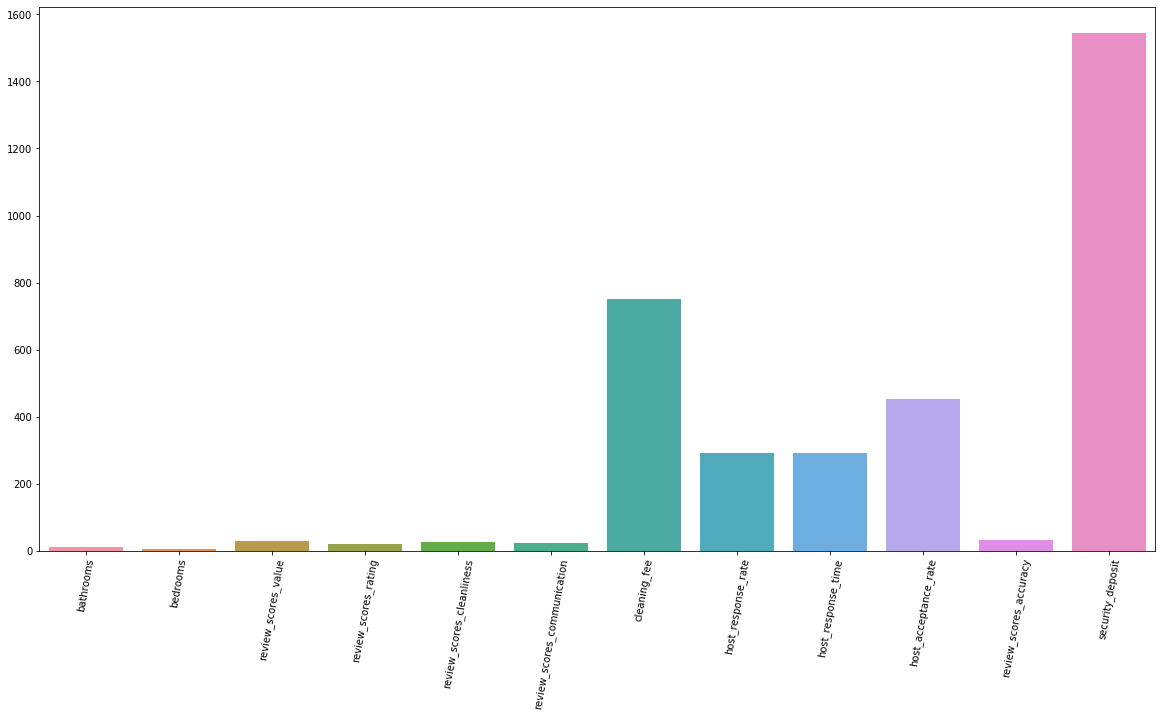

In [469]:
## lets see how many missing values exist 
## barplot of number of missing values 
plt.figure(figsize=(20,10))
plt.xticks(rotation=80)
plt.yticks()
sns.barplot(x=Data_Revenue.isnull().sum()[Data_Revenue.isnull().sum().nonzero()[0]].index,y=Data_Revenue.isnull().sum()[Data_Revenue.isnull().sum().nonzero()[0]].values)

In [438]:
# average revenue for each unique listing ID
Listing = Data_Revenue.groupby(['listing_id'])['revenue'].mean()
Listing

listing_id
4291         5740.000000
5682        46777.500000
6606         9880.000000
7369         3400.000000
9419        13693.333333
9460        85680.000000
9531        13650.000000
9534         3500.000000
9596        11760.000000
10385        8880.000000
10695        2616.000000
11012       44415.000000
11411        5640.000000
13068       33554.756757
14386        1200.000000
15108        2520.000000
17951        3864.000000
19611        8925.090909
19619        7514.000000
19623       18399.600000
20868       24934.000000
20927       40992.000000
20928        6512.000000
23192        2289.000000
23356        4095.000000
23430        8497.500000
23919        2970.000000
24212       17193.777778
26116       44460.952381
30712       14400.000000
                ...     
9679741        82.000000
9694921       485.500000
9698202      1028.916667
9706229      2037.000000
9711153       240.000000
9712716       195.000000
9714078       356.000000
9727246        92.000000
9727857       

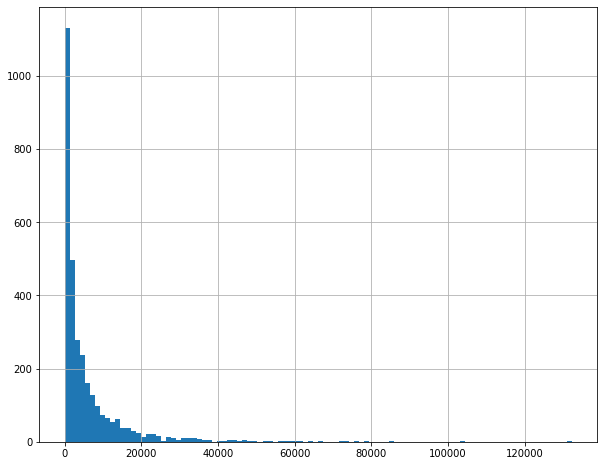

In [439]:
## how the total revenue for all the listings distributed
## how much each listing made 
Revenue_Per_Listing = Data_Revenue.groupby(['listing_id'])['revenue'].sum()
Revenue_Per_Listing = pd.DataFrame(Revenue_Per_Listing).reset_index()
Revenue_Per_Listing[Revenue_Per_Listing['revenue'] < 150000].revenue.hist(figsize=(10,8),bins=100)
## revenue is skewed to right

Text(0, 0.5, 'Price ($)')

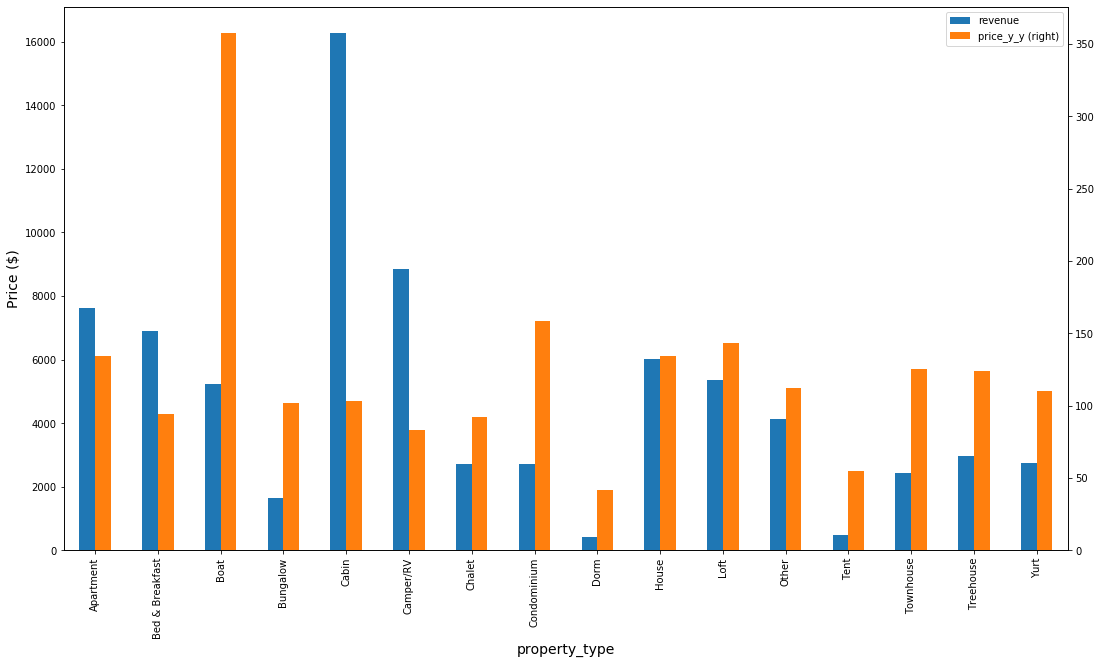

In [440]:
### revenue plot with property and room type 
price_vs_revenue = Data_Revenue.groupby(['property_type']).agg({'revenue':'mean','price_y_y':'mean'})
#price_vs_revenue.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)
fig, ax = plt.subplots(figsize=(18,10))
price_vs_revenue.plot.bar(y=['revenue','price_y_y'], secondary_y='price_y_y', ax=ax)
ax.set_xlabel("property_type",fontsize=14)
ax.set_ylabel("Price ($)",fontsize=14)


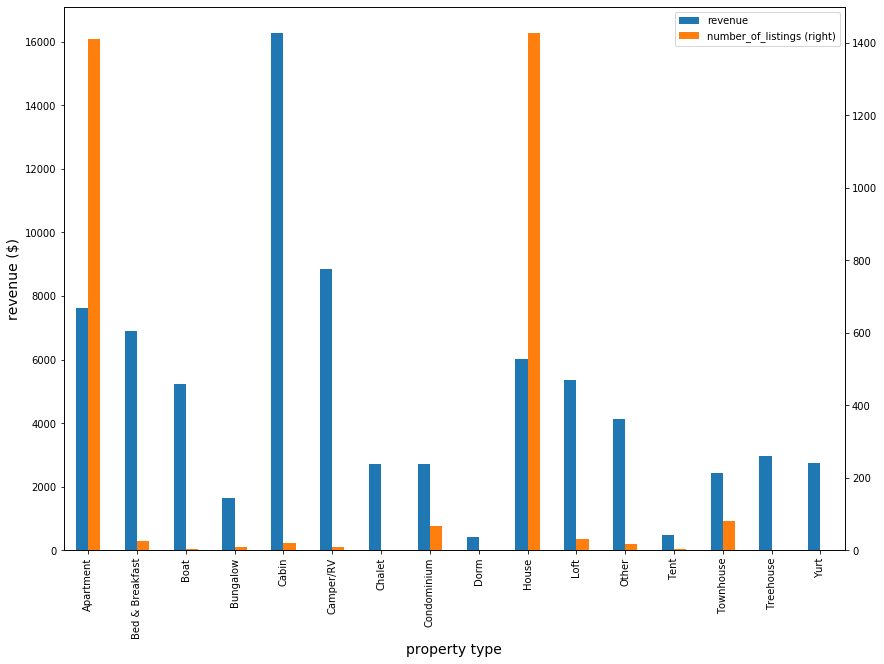

In [441]:
## howmuch each property cost vs how many times those properties listed over 2016 (plot 3)
price_vs_property = Data_Revenue.groupby(['property_type']).agg({'revenue':'mean','listing_id':'count'})
price_vs_property.rename(index=str, columns={"listing_id": "number_of_listings"},inplace=True)

fig, ax = plt.subplots(figsize=(14,10))
price_vs_property.plot.bar(y=['revenue','number_of_listings'], secondary_y='number_of_listings', ax=ax)
ax.set_xlabel("property type",fontsize=14)
ax.set_ylabel("revenue ($)",fontsize=14)
fig.savefig("revenue_for_each_property.jpg", bbox_inches='tight')

In [443]:
# find the revenue quartiles. I need to find a Threshold to define if a a listing is profitable and if not
Data_Revenue.revenue.describe()

count    3.118000e+03
mean     6.620010e+03
std      2.496312e+04
min      2.100000e+01
25%      7.860000e+02
50%      2.448000e+03
75%      6.936458e+03
max      1.200000e+06
Name: revenue, dtype: float64

In [470]:
## lets see how the revenue is distributed to find a good Threshold to diffrenciate "high revenue" and "low revenue"
# I choose 7000 to have more balanced response variable and names it performance
Data_Revenue['Performance'] = np.where(Data_Revenue['revenue'] >= 7000, 'Top', 'Low')

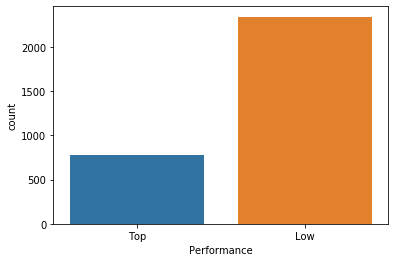

In [471]:
sns.countplot(x="Performance", data=Data_Revenue)

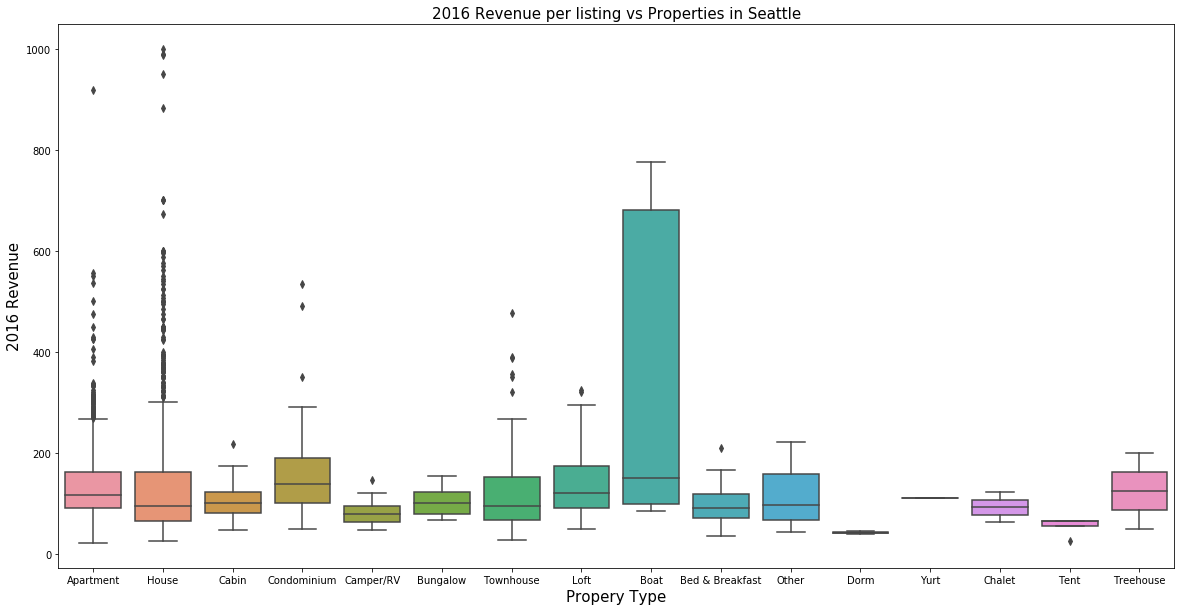

In [446]:
## barchart revenue vs property type
fig, ax = plt.subplots(figsize=(20,10));
bplot = sns.boxplot(x='property_type',y='price_y_y',data=Data_Revenue)
                
ax.set_title("2016 Revenue per listing vs Properties in Seattle",fontsize=15);
ax.set_xlabel("Propery Type", fontsize=15);
ax.set_ylabel("2016 Revenue", fontsize=15);


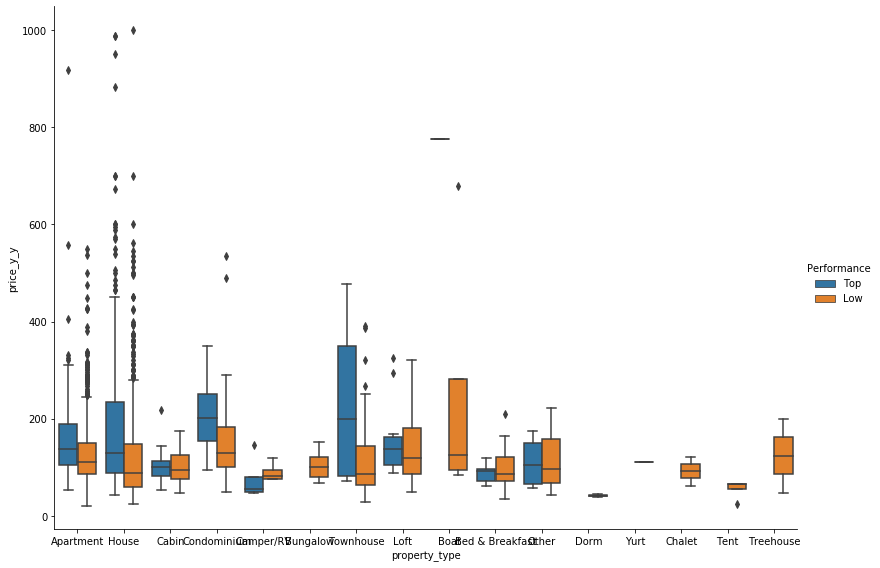

In [447]:
# bar chart property type vs price
sns.catplot(x="property_type", y="price_y_y", hue="Performance", kind="box",height=8, aspect=11.7/8.27, data=Data_Revenue)

In [472]:
# prepare the data for models' input by encoding and scaling

# encode binary variables that dont have missing values
binary_vars = ['require_guest_phone_verification','require_guest_profile_picture','host_is_superhost',\
                'instant_bookable','available']
for var in binary_vars:
    Data_Revenue[var] = np.where(Data_Revenue[var] == "t" ,1 , 0)
    
# encode categorical variables with more than two levels and keep the missings as a new level to data
# decided to have beds, bathrooms and bedrooms as categorical variable since we have missing values and dont want to loose 
# information but replacing them with zero or removing them 
categorical_vars = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type',\
                      'bed_type', 'cancellation_policy','require_guest_phone_verification','require_guest_profile_picture',\
                      'instant_bookable','year']
for var in categorical_vars:
     Data_Revenue = pd.concat([Data_Revenue.drop(var, axis=1),\
                        pd.get_dummies(Data_Revenue[var],\
                                       prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)
        
# replace othe missing values with the mean 
var_mean = ['bathrooms', 'bedrooms' ,'beds' ,'review_scores_value' ,'review_scores_rating','review_scores_cleanliness','cleaning_fee' ,
            'host_response_rate', 'host_acceptance_rate','review_scores_communication' ,'reviews_per_month', 'review_scores_accuracy','host_total_listings_count','security_deposit']

imputer = Imputer(strategy="mean")
Data_Revenue[var_mean] = imputer.fit_transform(Data_Revenue[var_mean])

### remove columns that has all zero values like instant bookable_nan
Data_Revenue = Data_Revenue.loc[:, (Data_Revenue != 0).any(axis=0)] 



C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [473]:
### scale numeric variables ready for fitting
col_names = ['bathrooms','bedrooms','beds','accommodates','availability_365','availability_30','availability_60',\
             'availability_90','number_of_reviews','price_y_y','review_scores_cleanliness','minimum_nights',\
             'guests_included','host_response_rate','host_acceptance_rate','host_total_listings_count',\
             'reviews_per_month', 'extra_people','cleaning_fee','minimum_nights','review_scores_value' ,'review_scores_rating',\
             'review_scores_accuracy','review_scores_communication','security_deposit']
features = Data_Revenue[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
Data_Revenue[col_names] = features

In [474]:
Data_Revenue.head()

,listing_id,bathrooms,bedrooms,accommodates,beds,host_is_superhost,availability_365,availability_30,availability_60,availability_90,number_of_reviews,review_scores_value,review_scores_rating,review_scores_cleanliness,review_scores_communication,minimum_nights,guests_included,cleaning_fee,host_response_rate,host_acceptance_rate,host_total_listings_count,extra_people,reviews_per_month,available,review_scores_accuracy,security_deposit,price_y_y,revenue,Performance,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Delridge,neighbourhood_cleansed_South Lake Union,neighbourhood_cleansed_South Park,neighbourhood_cleansed_Southeast Magnolia,neighbourhood_cleansed_Stevens,neighbourhood_cleansed_Sunset Hill,neighbourhood_cleansed_University District,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_View Ridge,neighbourhood_cleansed_Wallingford,neighbourhood_cleansed_Wedgwood,neighbourhood_cleansed_West Queen Anne,neighbourhood_cleansed_West Woodland,neighbourhood_cleansed_Westlake,neighbourhood_cleansed_Whittier Heights,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,p

In [475]:
## remove the id and revenue. Since I created Performance column I dont need revenue feature.
Data_Revenue = Data_Revenue.drop(['listing_id','revenue','minimum_nights','price_y_y', 'number_of_reviews'], axis = 1) 

In [476]:
### remove columns that has all zero values like instant bookable_nan
Data_Revenue= Data_Revenue.loc[:, (Data_Revenue != 0).any(axis=0)] 

In [477]:
# train-valid-test split
train, valid_test = train_test_split(Data_Revenue, test_size=0.2,random_state=1)
valid, test = train_test_split(valid_test, test_size=0.5,random_state=1)

Y_train = train['Performance']
X_train = train.drop(columns=['Performance'])

Y_valid = valid['Performance']
X_valid = valid.drop(columns=['Performance'])

Y_test = test['Performance']
X_test = test.drop(columns=['Performance'])

In [478]:
Data_Revenue.isnull().sum()

bathrooms                                0
bedrooms                                 0
accommodates                             0
beds                                     0
host_is_superhost                        0
availability_365                         0
availability_30                          0
availability_60                          0
availability_90                          0
review_scores_value                      0
review_scores_rating                     0
review_scores_cleanliness                0
review_scores_communication              0
guests_included                          0
cleaning_fee                             0
host_response_rate                       0
host_acceptance_rate                     0
host_total_listings_count                0
extra_people                             0
reviews_per_month                        0
available                                0
review_scores_accuracy                   0
security_deposit                         0
Performance

In [479]:
# benchmark model, GBM
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, random_state=0)
    gb_clf.fit(X_train, Y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_valid, Y_valid)))


Learning rate:  0.05
Accuracy score (training): 0.769
Accuracy score (validation): 0.772
Learning rate:  0.075
Accuracy score (training): 0.799
Accuracy score (validation): 0.798
Learning rate:  0.1
Accuracy score (training): 0.814
Accuracy score (validation): 0.801
Learning rate:  0.25
Accuracy score (training): 0.854
Accuracy score (validation): 0.808
Learning rate:  0.5
Accuracy score (training): 0.876
Accuracy score (validation): 0.830
Learning rate:  0.75
Accuracy score (training): 0.885
Accuracy score (validation): 0.817
Learning rate:  1
Accuracy score (training): 0.894
Accuracy score (validation): 0.814


Accuracy of the GBM on valid set: 0.817
              precision    recall  f1-score   support

         Low       0.86      0.90      0.88       233
         Top       0.66      0.57      0.61        79

    accuracy                           0.82       312
   macro avg       0.76      0.74      0.75       312
weighted avg       0.81      0.82      0.81       312

Confusion Matrix:
[[210  23]
 [ 34  45]]


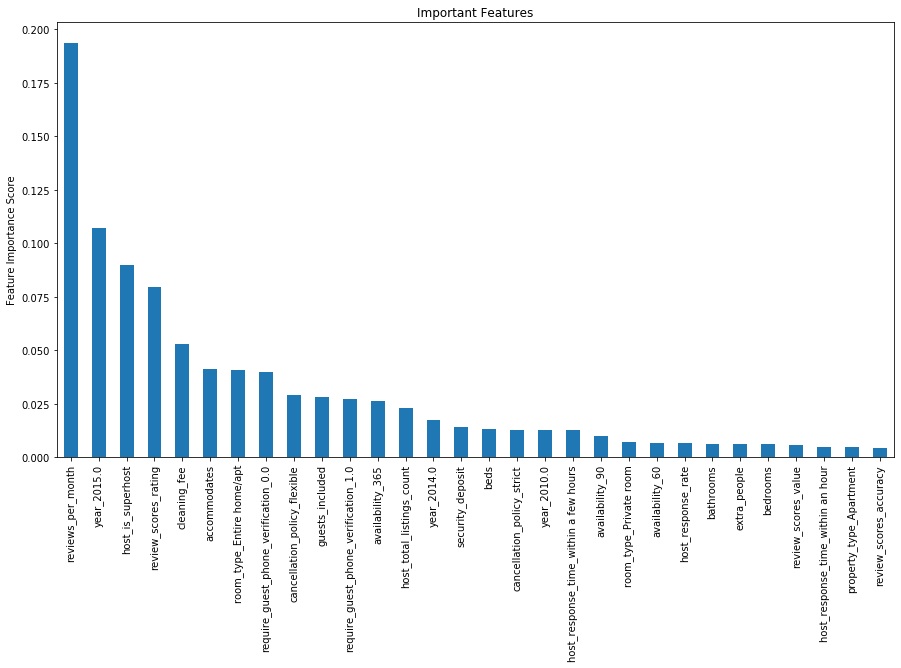

In [481]:
#### find important variables, confusion matrix for benchmark model
baseline = GradientBoostingClassifier(random_state=10)
baseline.fit(X_train,Y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False).head(30)
feat_imp.plot(kind='bar', title='Important Features', figsize=(15,8))
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on valid set: {:.3f}'.format(baseline.score(X_valid, Y_valid)))
pred=baseline.predict(X_valid)
print(classification_report(Y_valid, pred))
print("Confusion Matrix:")
print(confusion_matrix(Y_valid, pred))

In [482]:
#### lets tune the GB model and find the best parameters :  learning rate and number of trees

p_test = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001] ,'n_estimators':[10,20,50, 100, 500]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_features='sqrt', random_state=10), 
            param_grid = p_test, scoring='accuracy',n_jobs=-1, cv=10)

tuning.fit(X_train,Y_train)

means = tuning.cv_results_['mean_test_score']
stds = tuning.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuning.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

tuning.best_score_ , tuning.best_params_   

0.762 (+/-0.016) for {'learning_rate': 0.15, 'n_estimators': 10}
0.792 (+/-0.030) for {'learning_rate': 0.15, 'n_estimators': 20}
0.810 (+/-0.033) for {'learning_rate': 0.15, 'n_estimators': 50}
0.818 (+/-0.031) for {'learning_rate': 0.15, 'n_estimators': 100}
0.823 (+/-0.044) for {'learning_rate': 0.15, 'n_estimators': 500}
0.755 (+/-0.014) for {'learning_rate': 0.1, 'n_estimators': 10}
0.773 (+/-0.027) for {'learning_rate': 0.1, 'n_estimators': 20}
0.799 (+/-0.033) for {'learning_rate': 0.1, 'n_estimators': 50}
0.819 (+/-0.035) for {'learning_rate': 0.1, 'n_estimators': 100}
0.825 (+/-0.038) for {'learning_rate': 0.1, 'n_estimators': 500}
0.749 (+/-0.003) for {'learning_rate': 0.05, 'n_estimators': 10}
0.754 (+/-0.008) for {'learning_rate': 0.05, 'n_estimators': 20}
0.775 (+/-0.030) for {'learning_rate': 0.05, 'n_estimators': 50}
0.800 (+/-0.026) for {'learning_rate': 0.05, 'n_estimators': 100}
0.826 (+/-0.037) for {'learning_rate': 0.05, 'n_estimators': 500}
0.749 (+/-0.003) for {'l

(0.8259823576583801, {'learning_rate': 0.05, 'n_estimators': 500})

In [486]:
## fit the best model and find the accuracy for test data
best_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, random_state=10)
best_model.fit(X_train,Y_train)

predictors=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, predictors).sort_values(ascending=False).head(30)

print('Accuracy of the GBM on test set: {:.3f}'.format(best_model.score(X_test, Y_test)))
pred = best_model.predict(X_test)
print(classification_report(Y_test, pred))

Accuracy of the GBM on test set: 0.843
              precision    recall  f1-score   support

         Low       0.89      0.91      0.90       243
         Top       0.66      0.59      0.63        69

    accuracy                           0.84       312
   macro avg       0.77      0.75      0.76       312
weighted avg       0.84      0.84      0.84       312



In [511]:
# lets see how other classification algorithms perform 
# as it is shown in the output, Gradient Boosted Classifier has the highest accuracy

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


classifiers = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(gamma ='auto'),
    "DecisionTreeClassifier": GradientBoostingClassifier()
}

In [512]:
## print the accuracy for all
for key, classifier in classifiers.items():
    classifier.fit(X_train, Y_train)
    training_score = cross_val_score(classifier, X_train, Y_train, cv=10)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 81.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 77.0 % accuracy score
Classifiers:  SVC Has a training score of 80.0 % accuracy score
Classifiers:  GradientBoostingClassifier Has a training score of 82.0 % accuracy score


In [525]:
# find the predicted performance label on test data set
pred = best_model.predict(X_test)

In [534]:
pred

array(['Low', 'Top', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Top', 'Low', 'Low', 'Top', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Top', 'Low', 'Low', 'Top', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Top', 'Top', 'Low', 'Top', 'Low', 'Low',
       'Top', 'Low', 'Low', 'Low', 'Low', 'Top', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Low', 'Top', 'Top', 'Top', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Top', 'Top', 'Low', 'Low', 'Low', 'Top',
       'Low', 'Low', 'Top', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Low', 'Low', 'Top', 'Top', 'Low', 'Top',
       'Low', 'Low', 'Low', 'Low', 'Top', 'Low', 'Top', 'Low', 'Top',
       'Top', 'Low', 'Low', 'Top', 'Low', 'Top', 'Low', 'Top', 'Top',
       'Low', 'Low', 'Low', 'Low', 'Top', 'Top', 'Top', 'Low', 'Low',
       'Top', 'Low', 'Low', 'Low', 'Low', 'Top', 'Top', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Low', 'Low', 'Top', 'Low', 'Low', 'Low',
       'Low', 'Low',